# Taking Full Advantage of Parallelism With Data Distribution
_**Using Amazon SageMaker's Managed, Distributed Training with Different Data Distribution Methods**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
  1. [Scaling](#Scaling)
1. [Training-Hosting](#Training-Hosting)
1. [Evaluate](#Evaluate)


This notebook contains two parts of the Parallelized Data Distribution module of the Built-in Algorithms workshop. More specifically, it covers exploratory data analysis and evaluation of the trained models; training and deployment of the models is covered in the workshop lab guide.

---
# Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying the S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting. The IAM role for S3 data access is pulled in from the SageMaker Notebook Instance.  After you have replaced the bucket name, go ahead and run the cell by clicking the 'Run cell' button in the toolbar above, or using Control + Enter from your keyboard.

In [1]:
# S3 bucket and prefix
bucket = 'smworkshop-john-smith'
prefix = 'sagemaker/data_distribution_types'

import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [2]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import io
import time
import copy
import json
import sys
import sagemaker.amazon.common as smac
import os
import warnings
warnings.simplefilter("ignore")

---

## Data

The [dataset](https://aws.amazon.com/public-datasets/gdelt/) we'll use for this notebook is from the [Global Database of Events, Language and Tone (GDELT) Project](https://www.gdeltproject.org/).  This information is freely available on S3 as part of the [AWS Public Datasets](https://aws.amazon.com/public-datasets/) program.

The data are stored as multiples files on S3, with two different formats: historical, which covers from 1979 to 2013, and daily updates which covers from 2013 on.  For this example, we'll stick to historical.  Let's bring in 1979 data for the purpose of interactive exploration.  We'll write a simple function so that later we can use it to download multiple files. Among other actions, the function downloads the data from the public S3 bucket, and reads it into a Pandas dataframe.  

In [3]:
def get_gdelt(filename):
    s3 = boto3.resource('s3')
    s3.Bucket('gdelt-open-data').download_file('events/' + filename, '.gdelt.csv')
    df = pd.read_csv('.gdelt.csv', sep='\t')
    header = pd.read_csv('https://www.gdeltproject.org/data/lookups/CSV.header.historical.txt', sep='\t')
    df.columns = header.columns
    return df

In [4]:
data = get_gdelt('1979.csv')
data

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED
0,1,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,8.0000,0,1.0,Nigeria,NI,NI,10.0000,8.0000,0.0,20130203
1,2,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,8.0000,0,1.0,Nigeria,NI,NI,10.0000,8.0000,0.0,20130203
2,3,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,106.3590,-1903584,4.0,"Dizhou, Guangxi, China",CH,CH16,23.0036,106.3590,-1903584.0,20130203
3,4,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,-96.8067,1380944,3.0,"Dallas, Texas, United States",US,USTX,32.7831,-96.8067,1380944.0,20130203
4,5,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,34.6809,-779676,4.0,"Emunim, HaDarom, Israel",IS,IS01,31.7444,34.6809,-779676.0,20130203
5,6,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,0.0000,0,NaN,NaN,NaN,NaN,0.0000,0.0000,NaN,20130203
6,7,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,35.0000,0,1.0,Turkey,TU,TU,39.0000,35.0000,0.0,20130203
7,8,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,116.3880,-1898541,4.0,"Peiping, Beijing, China",CH,CH22,39.9289,116.3880,-1898541.0,20130203
8,9,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,119.0000,-2637942,4.0,"Peiping, Beijing, China",CH,CH22,39.9289,116.3880,-1898541.0,20130203
9,10,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,14.5939,-531881,4.0,"Szczecin, Zachodniopomorskie, Poland",PL,PL87,53.4395,14.5939,-531881.0,20130203


As we can see, there are 57 columns (you may not be able to see all 57 as they may be truncated for display purposes).  Some of the columns are sparsely populated, cryptically named, and in a format that's not particularly friendly for machine learning.  So, for our use case, we'll strip down to a few core attributes.  We'll use:

- `EventCode`: This is the raw CAMEO action code describing the action that Actor1 performed upon Actor2.  More detail can be found [here](https://www.gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf)
- `NumArticles`:  This is the total number of source documents containing one or more mentions of this event. This can be used as a method of assessing the “importance” of an event; the more discussion of that event, the more likely it is to be significant
- `AvgTone`: This is the average “tone” of all documents containing one or more mentions of this event. The score ranges from -100 (extremely negative) to +100 (extremely positive). Common values range between -10 and +10, with 0 indicating neutral.
- `Actor1Geo_Lat`: This is the centroid latitude of the Actor1 landmark for mapping.
- `Actor1Geo_Long`: This is the centroid longitude of the Actor1 landmark for mapping.
- `Actor2Geo_Lat`: This is the centroid latitude of the Actor2 landmark for mapping.
- `Actor2Geo_Long`: This is the centroid longitude of the Actor2 landmark for mapping.

col_0,% observations
EventCode,
10,0.060275
11,0.001703
12,0.013786
13,0.014074
14,0.006790
15,0.002172
16,0.002880
17,0.007818
18,0.001283


,NumArticles,AvgTone,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Lat,Actor2Geo_Long
count,430940.000000,430940.000000,430940.000000,430940.000000,430940.000000,430940.000000
mean,4.369694,5.127215,26.311911,26.111038,23.109048,23.637813
std,3.121310,2.637798,21.865323,61.125843,22.136466,57.693612
min,1.000000,0.000000,-85.622100,-179.050000,-85.622100,-179.050000
25%,2.000000,3.333333,10.000000,0.000000,0.000000,0.000000
50%,4.000000,5.000000,32.000000,28.229400,30.044500,19.500000
75%,6.000000,6.666667,40.400000,53.000000,39.928900,50.093800
max,54.000000,28.571429,85.000000,180.000000,85.000000,180.000000


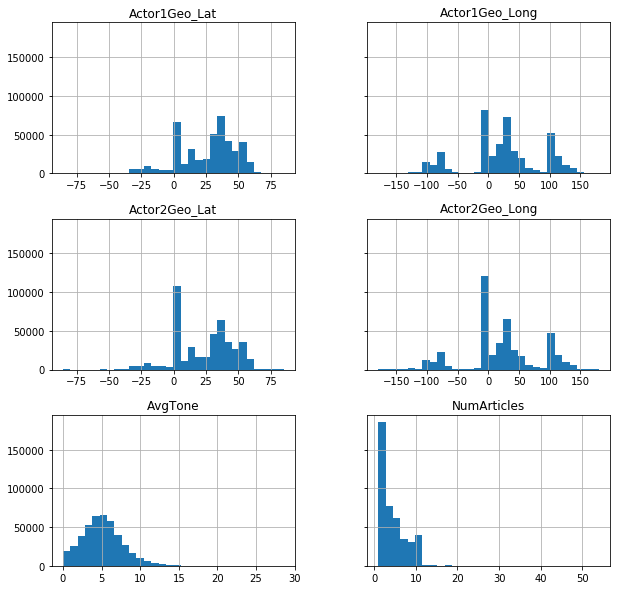

In [5]:
data = data[['EventCode', 'NumArticles', 'AvgTone', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']]
data['EventCode'] = data['EventCode'].astype(object)

for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns'))

display(data.describe())
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))
plt.show()

We can see:
- `EventCode` is pretty unevenly distributed, with some events making up 7%+ of the observations and others being a thousandth of a percent.
- `AvgTone` seems to be reasonably smoothly distributed, while `NumArticles` has a long tail, and `Actor` geo features have suspiciously large spikes near 0.

Let's remove the (0, 0) lat-longs, one hot encode `EventCode`, and prepare our data for a machine learning model.  For this example we'll keep things straightforward and try to predict `AvgTone`, using the other variables in our dataset as features.

One more issue remains.  As we noticed above, some occurrences of `EventCode` are very rare, and may be unlikely to occur in every single year.  This means if we one hot encode individual years at a time, our feature matrix may change shape over the years, which will not work.  Therefore, we'll limit all years to the most common `EventCodes` from the year we current have.  Let's get this list.

In [6]:
events = pd.crosstab(index=data['EventCode'], columns='count').sort_values(by='count', ascending=False).index[:20]

### Scaling

Now that we've explored our data and are ready to prepare for modeling, we can start developing a few simple functions to help us scale this to GDELT datasets from other years.

In [7]:
def write_to_s3(bucket, prefix, channel, file_prefix, X, y):
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, X.astype('float32'), y.astype('float32'))
    buf.seek(0)
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, channel, file_prefix + '.data')).upload_fileobj(buf)

def transform_gdelt(df, events=None):
    df = df[['AvgTone', 'EventCode', 'NumArticles', 'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Lat', 'Actor2Geo_Long']]
    df['EventCode'] = df['EventCode'].astype(object)
    if events is not None:
        df = df[np.in1d(df['EventCode'], events)]
    return pd.get_dummies(df[((df['Actor1Geo_Lat'] == 0) & (df['Actor1Geo_Long'] == 0) != True) &
                                   ((df['Actor2Geo_Lat'] == 0) & (df['Actor2Geo_Long'] == 0) != True)])
    
def prepare_gdelt(bucket, prefix, file_prefix, events=None, random_state=1729):
    df = get_gdelt(file_prefix + '.csv')
    model_data = transform_gdelt(df, events)
    train_data, validation_data = np.split(model_data.sample(frac=1, random_state=random_state).as_matrix(), 
                                           [int(0.9 * len(model_data))])
    write_to_s3(bucket, prefix, 'train', file_prefix, train_data[:, 1:], train_data[:, 0])
    write_to_s3(bucket, prefix, 'validation', file_prefix, validation_data[:, 1:], validation_data[:, 0])

In [8]:
for year in range(1979, 1984):
    prepare_gdelt(bucket, prefix, str(year), events)

---

## Training-Hosting

Next, we'll set up training jobs and deploy the resulting models.  For those steps, please return to the workshop lab guide after the previous code cell completes running, which may take a few minutes.  You'll return to this notebook for the final evaluation steps.


---

## Evaluate

To compare predictions from our two models, let's bring in some new data from a year the model was not trained or validated on.

In [9]:
test_data = transform_gdelt(get_gdelt('1984.csv'), events).as_matrix()
test_X = test_data[:, 1:]
test_y = test_data[:, 0]

Now we'll need a function to convert these numpy matrices to CSVs so they can be passed to our endpoint as an HTTP POST request.

In [10]:
def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()

Next, because POST requests to our endpoint are limited to ~6MB, we'll setup a small function to split our test data up into mini-batches that are each about 5MB, loop through and invoke our endpoint to get predictions for those mini-batches, and gather them into a single array. 

In [11]:
def predict_batches(data, endpoint):
    rows = 5. * 1024. * 1024. / sys.getsizeof(np2csv(data[0, :]))
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    runtime = boto3.Session().client('runtime.sagemaker')
    for array in split_array:
        payload = np2csv(array)
        response = runtime.invoke_endpoint(EndpointName=endpoint,
                                           ContentType='text/csv',
                                           Body=payload)
        result = json.loads(response['Body'].read().decode())
        predictions += [r['score'] for r in result['predictions']]
    return np.array(predictions)

We're almost ready to get the predictions. First, however, we need to bring in the names of the endpoints we created in the previous section of the module. If you followed the naming convention in the lab guide, the names are already filled in for the code cell below. Otherwise, replace the names with the ones you chose.

In [12]:
sharded_endpoint = 'distributed-sharded'
replicated_endpoint = 'distributed-replicated'

Now we'll compare accuracy in mean squared error (MSE).

In [13]:
sharded_predictions = predict_batches(test_X, sharded_endpoint)
replicated_predictions = predict_batches(test_X, replicated_endpoint)

print('Sharded MSE =', np.mean((test_y - sharded_predictions) ** 2))
print('Replicated MSE =', np.mean((test_y - replicated_predictions) ** 2))

Sharded MSE = 5.05978395321
Replicated MSE = 5.05407818863


We can see that the fully replicated distribution type performs just slightly better in terms of fit.  However, this difference is small compared to the overall speedup achieved by dividing the data set into multiple S3 objects and distributing them across machines.

This concludes the notebook portion of this module.  Please return to the workshop lab guide.